In [1]:
!pip show tensorflow

Name: tensorflow
Version: 2.17.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os

def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_dir = '/content/drive/MyDrive/Colab Notebooks/BDM/dataset/UAS/train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/BDM/dataset/UAS/val'
test_dir = '/content/drive/MyDrive/Colab Notebooks/BDM/dataset/UAS/test'

print("Training Data Distribution:", count_images(train_dir))
print("Validation Data Distribution:", count_images(val_dir))
print("Testing Data Distribution:", count_images(test_dir))

Training Data Distribution: {'TURBERCULOSIS': 650, 'PNEUMONIA': 3875, 'NORMAL': 1341, 'COVID19': 460}
Validation Data Distribution: {'TURBERCULOSIS': 12, 'PNEUMONIA': 8, 'NORMAL': 8, 'COVID19': 10}
Testing Data Distribution: {'TURBERCULOSIS': 41, 'PNEUMONIA': 390, 'NORMAL': 234, 'COVID19': 106}


In [10]:
import pandas as pd

def count_images_table(train_dir, val_dir, test_dir):

    train_counts = count_images(train_dir)
    val_counts = count_images(val_dir)
    test_counts = count_images(test_dir)

    data = {
        "Class": list(train_counts.keys()),
        "Train": list(train_counts.values()),
        "Validation": [val_counts.get(cls, 0) for cls in train_counts.keys()],
        "Test": [test_counts.get(cls, 0) for cls in train_counts.keys()],
    }
    df = pd.DataFrame(data)

    total_row = {
        "Class": "Total",
        "Train": sum(train_counts.values()),
        "Validation": sum(val_counts.values()),
        "Test": sum(test_counts.values()),
    }
    df = pd.concat([df, pd.DataFrame([total_row])], ignore_index=True)

    return df

df = count_images_table(train_dir, val_dir, test_dir)

styled_df = df.style.background_gradient(subset=["Train", "Validation", "Test"], cmap="YlGnBu") \
                    .set_table_styles([{
                        'selector': 'thead th',
                        'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-size', '16px')]
                    }, {
                        'selector': 'tbody td',
                        'props': [('text-align', 'center'), ('font-size', '14px')]
                    }])
styled_df.to_html("data_distribution.html")
styled_df


,Class,Train,Validation,Test
0,TURBERCULOSIS,650,12,41
1,PNEUMONIA,3875,8,390
2,NORMAL,1341,8,234
3,COVID19,460,10,106
4,Total,6326,38,771


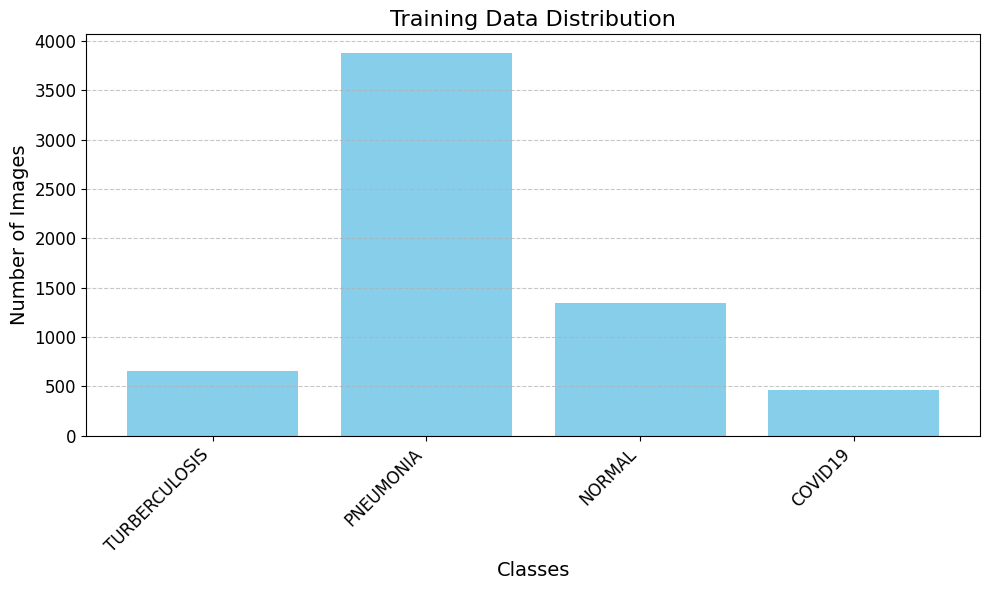

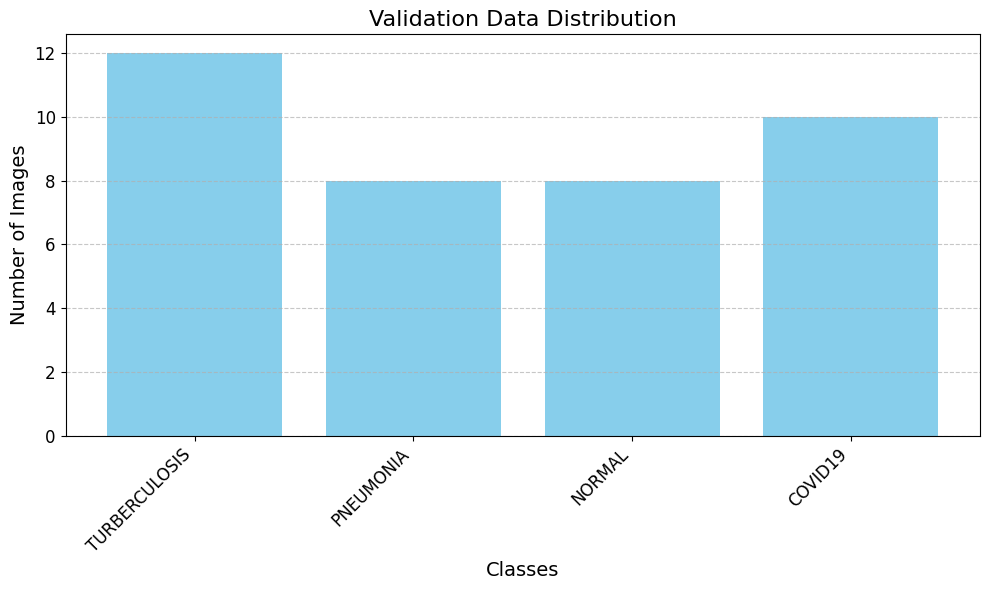

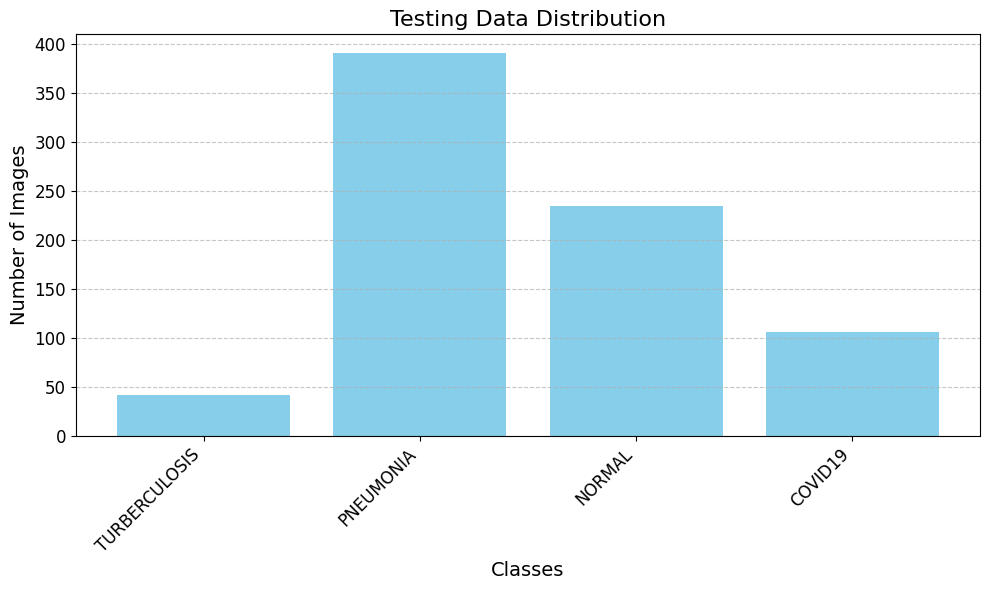

In [8]:
import matplotlib.pyplot as plt

def plot_class_distribution(class_counts, title):
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.title(title, fontsize=16)
    plt.xlabel('Classes', fontsize=14)
    plt.ylabel('Number of Images', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_class_distribution(count_images(train_dir), "Training Data Distribution")
plot_class_distribution(count_images(val_dir), "Validation Data Distribution")
plot_class_distribution(count_images(test_dir), "Testing Data Distribution")

In [ ]:
# @title Default title text
import os
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Parameters
img_size = 224  # Input image size for DenseNet121
batch_size = 32
num_classes = 4
epochs = 20
train_dir = r'/content/drive/MyDrive/Colab Notebooks/BDM/dataset/UAS/train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/BDM/dataset/UAS/val'

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Model Setup
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Optional Dense layer
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Colab Notebooks/BDM/dataset/UAS/best_model.keras',  # Save the best model in Keras format
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[checkpoint, early_stop]
)

# Fine-tuning: Unfreeze some base model layers and train further
for layer in base_model.layers[-50:]:  # Unfreeze last 50 layers
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue Training
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[checkpoint, early_stop]
)

# Save Final Model
model.save('/content/drive/MyDrive/Colab Notebooks/BDM/dataset/UAS/final_model.keras')  # Save final model in Keras format

# Optionally Save in .h5 Format
model.save('/content/drive/MyDrive/Colab Notebooks/BDM/dataset/UAS/final_model.h5')  # For compatibility with older systems

Found 6326 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


198/198 ━━━━━━━━━━━━━━━━━━━━ 2396s 12s/step - accuracy: 0.8141 - loss: 0.4817 - val_accuracy: 0.7895 - val_loss: 0.3723
Epoch 2/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1249s 6s/step - accuracy: 0.9333 - loss: 0.1816 - val_accuracy: 0.8421 - val_loss: 0.3531
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1282s 6s/step - accuracy: 0.9404 - loss: 0.1533 - val_accuracy: 0.9211 - val_loss: 0.1899
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1281s 6s/step - accuracy: 0.9429 - loss: 0.1446 - val_accuracy: 0.8684 - val_loss: 0.3372
Epoch 5/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1248s 6s/step - accuracy: 0.9579 - loss: 0.1096 - val_accuracy: 0.8684 - val_loss: 0.3008
Epoch 6/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1255s 6s/step - accuracy: 0.9505 - loss: 0.1352 - val_accuracy: 0.7895 - val_loss: 0.5576
Epoch 7/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1281s 6s/step - accuracy: 0.9465 - loss: 0.1417 - val_accuracy: 0.8947 - val_loss: 0.1957
Epoch 8/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1283s 6s/step - accuracy: 0.9474 - loss: 0.1422 - val_accura

In [ ]:
test_dir = '/content/drive/MyDrive/Colab Notebooks/BDM/dataset/UAS/test'

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure the order of predictions matches the filenames
)

from tensorflow.keras.models import load_model

# Load the best model
model = load_model('/content/drive/MyDrive/Colab Notebooks/BDM/dataset/UAS/best_model.keras')  # Or final_model.keras

Found 771 images belonging to 4 classes.


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 513s 21s/step - accuracy: 0.8611 - loss: 0.4930
Test Accuracy: 0.89
Test Loss: 0.41


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict probabilities
predictions = model.predict(test_generator)

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

25/25 ━━━━━━━━━━━━━━━━━━━━ 156s 6s/step
               precision    recall  f1-score   support

      COVID19       0.92      0.96      0.94       106
       NORMAL       0.93      0.70      0.80       234
    PNEUMONIA       0.87      0.97      0.92       390
TURBERCULOSIS       0.75      0.98      0.85        41

     accuracy                           0.89       771
    macro avg       0.87      0.90      0.88       771
 weighted avg       0.89      0.89      0.88       771

Confusion Matrix:
 [[102   0   0   4]
 [  8 164  54   8]
 [  0  12 377   1]
 [  1   0   0  40]]


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load and preprocess the image
image_path = '/content/drive/MyDrive/Colab Notebooks/BDM/dataset/UAS/test/COVID19/COVID19(466).jpg'
img = load_img(image_path, target_size=(img_size, img_size))
img_array = img_to_array(img) / 255.0  # Rescale
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict
single_prediction = model.predict(img_array)
predicted_class = class_labels[np.argmax(single_prediction)]
print(f"Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Class: COVID19


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load and preprocess the image
image_path = '/content/drive/MyDrive/Colab Notebooks/BDM/dataset/UAS/test/TURBERCULOSIS/Tuberculosis-663.png'
img = load_img(image_path, target_size=(img_size, img_size))
img_array = img_to_array(img) / 255.0  # Rescale
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict
single_prediction = model.predict(img_array)
predicted_class = class_labels[np.argmax(single_prediction)]
print(f"Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
Predicted Class: TURBERCULOSIS


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Parameters
img_size = 224  # Input image size for DenseNet121
batch_size = 32
num_classes = 4
epochs = 20
train_dir = r'//content/drive/MyDrive/Colab Notebooks/BDM/dataset/UAS/train'
val_dir = r'/content/drive/MyDrive/Colab Notebooks/BDM/dataset/UAS/val'

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Model Setup
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Optional Dense layer
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Callbacks
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Colab Notebooks/BDM/dataset/UAS/best_balanced_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[checkpoint, early_stop]
)

# Fine-tuning: Unfreeze some base model layers and train further
for layer in base_model.layers[-50:]:  # Unfreeze last 50 layers
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue Training
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[checkpoint, early_stop]
)

# Save Final Model
model.save('/content/drive/MyDrive/Colab Notebooks/BDM/dataset/UAS/final_balanced_model.keras')

# Optionally Save in .h5 Format
model.save('/content/drive/MyDrive/Colab Notebooks/BDM/dataset/UAS/final_balanced_model.h5')

Found 6326 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


198/198 ━━━━━━━━━━━━━━━━━━━━ 1295s 6s/step - accuracy: 0.8593 - loss: 0.4026 - val_accuracy: 0.7368 - val_loss: 0.3970
Epoch 2/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1273s 6s/step - accuracy: 0.9314 - loss: 0.1747 - val_accuracy: 0.9211 - val_loss: 0.1714
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1252s 6s/step - accuracy: 0.9252 - loss: 0.1946 - val_accuracy: 0.8947 - val_loss: 0.2450
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1261s 6s/step - accuracy: 0.9536 - loss: 0.1222 - val_accuracy: 0.9211 - val_loss: 0.1276
Epoch 5/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1265s 6s/step - accuracy: 0.9437 - loss: 0.1492 - val_accuracy: 0.8421 - val_loss: 0.2461
Epoch 6/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1247s 6s/step - accuracy: 0.9574 - loss: 0.1177 - val_accuracy: 0.8947 - val_loss: 0.3221
Epoch 7/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1248s 6s/step - accuracy: 0.9508 - loss: 0.1356 - val_accuracy: 0.9211 - val_loss: 0.2024
Epoch 8/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 1286s 6s/step - accuracy: 0.9496 - loss: 0.1249 - val_accurac

In [ ]:
test_dir = '/content/drive/MyDrive/Colab Notebooks/BDM/dataset/UAS/test'

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure the order of predictions matches the filenames
)

from tensorflow.keras.models import load_model

# Load the best model
model = load_model('/content/drive/MyDrive/Colab Notebooks/BDM/dataset/UAS/best_balanced_model.keras')  # Best model for balanced data

Found 771 images belonging to 4 classes.


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 149s 5s/step - accuracy: 0.8904 - loss: 0.3626
Test Accuracy: 0.90
Test Loss: 0.31


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict probabilities
predictions = model.predict(test_generator)

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

25/25 ━━━━━━━━━━━━━━━━━━━━ 152s 6s/step
               precision    recall  f1-score   support

      COVID19       0.97      0.99      0.98       106
       NORMAL       0.94      0.74      0.83       234
    PNEUMONIA       0.87      0.97      0.92       390
TURBERCULOSIS       0.97      0.95      0.96        41

     accuracy                           0.90       771
    macro avg       0.94      0.91      0.92       771
 weighted avg       0.91      0.90      0.90       771

Confusion Matrix:
 [[105   1   0   0]
 [  1 173  59   1]
 [  0  11 379   0]
 [  2   0   0  39]]
